# Entrenamiento de algoritmo de forecasting de demanda

**Objetivo:** entrenar un modelo de series de tiempo con datos hasta 2022-04 y generar pronósticos para 2022-05, 2022-06 y 2022-07. Se guardan:
- `output/forecast_full_series.csv` con la serie completa + pronóstico.
- Gráfico con train/valid/forecast y métricas (RMSE, MAE, MAPE).

---


### Setup

In [2]:
# Standard library
import os
import unicodedata
import warnings
from pathlib import Path

# Third-party general
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Time utilities
from pandas.tseries.offsets import DateOffset

# Models / ML libraries
from xgboost import XGBRegressor
from prophet import Prophet
from scipy.stats import randint, uniform

# Stats / time series
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Scikit-learn (model selection, models, preprocessing, pipeline, metrics)
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    KFold,
    cross_val_score,
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Config / housekeeping
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12, 5)

OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

### Carga de datos

In [3]:
# Cargar datasets
df_demand = pd.read_csv("../data/raw/dataset_demand_acumulate.csv")
df_alpha = pd.read_csv("../data/raw/dataset_alpha_betha.csv")
df_pred = pd.read_csv("../data/raw/to_predict.csv")

### Formateo de variables

In [4]:
def normalize_text(s):
    if pd.isna(s):
        return s
    s = str(s).strip().upper()
    s = ''.join(c for c in unicodedata.normalize("NFKD", s) if unicodedata.category(c) != "Mn")
    return s

# ---------- df_demand ----------
# parsear fecha y asegurar numérico (nombres reales: year_month, Demand)
df_demand["year_month"] = pd.to_datetime(df_demand["year_month"], format="%Y-%m", errors="coerce")
df_demand["Demand"] = pd.to_numeric(df_demand["Demand"], errors="coerce")
df_demand = df_demand.sort_values("year_month").reset_index(drop=True)

# ---------- df_alpha ----------
# normalizar texto en columnas object (excepto autoID)
obj_cols = [c for c in df_alpha.select_dtypes(include="object").columns if c != "autoID"]
for c in obj_cols:
    df_alpha[c] = df_alpha[c].apply(normalize_text)

# unificar etiquetas erróneas y asegurar tipos numéricos
if "Class" in df_alpha.columns:
    df_alpha["Class"] = df_alpha["Class"].replace({"BETHA": "BETA"}) 
    df_alpha["Class"] = df_alpha["Class"].astype("category")

if "Demand" in df_alpha.columns:
    df_alpha["Demand"] = pd.to_numeric(df_alpha["Demand"], errors="coerce")

if "Charges" in df_alpha.columns:
    df_alpha["Charges"] = pd.to_numeric(df_alpha["Charges"], errors="coerce")

# ---------- df_pred ----------
# aplicar misma normalización que en df_alpha
for c in df_pred.select_dtypes(include="object").columns:
    df_pred[c] = df_pred[c].apply(normalize_text)

if "Charges" in df_pred.columns:
    df_pred["Charges"] = pd.to_numeric(df_pred["Charges"], errors="coerce")

# ---------- checks rápidos ----------
print("df_demand:", df_demand.shape)
print(df_demand.dtypes)

print("\ndf_alpha:", df_alpha.shape)
print(df_alpha[["Demand", "Charges"]].describe(include="all"))
print("\nClass distribution:\n", df_alpha["Class"].value_counts(dropna=False))

print("\ndf_pred:", df_pred.shape)
print(df_pred.dtypes)

df_demand: (64, 2)
year_month    datetime64[ns]
Demand               float64
dtype: object

df_alpha: (7043, 16)
            Demand      Charges
count  7032.000000  7043.000000
mean   2283.300441    64.761692
std    2266.771362    30.090047
min      18.800000    18.250000
25%     401.450000    35.500000
50%    1397.475000    70.350000
75%    3794.737500    89.850000
max    8684.800000   118.750000

Class distribution:
 Class
ALPHA    5174
BETA     1869
Name: count, dtype: int64

df_pred: (3, 16)
autoID               object
SeniorCity            int64
Partner              object
Dependents           object
Service1             object
Service2             object
Security             object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
Contract             object
PaperlessBilling     object
PaymentMethod        object
Charges             float64
Demand              float64
Class               float64
dtype: object


### Split y validación con Modelos ML - Fenomeno tabular con relaciones no paramétricas

In [5]:
# --------- Datos ---------
X = df_alpha.drop(columns=["Demand"])
y = df_alpha["Demand"].fillna(df_alpha["Demand"].mean())

# --------- Columnas por tipo ---------
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

# --------- Preprocesamiento ---------
preprocesador = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

# --------- Modelos y espacios de hiperparámetros ---------
from xgboost import XGBRegressor

modelos = {
    "Ridge": (Ridge(), {"model__alpha": uniform(0.01, 10)}),
    "Lasso": (Lasso(max_iter=5000), {"model__alpha": uniform(0.001, 1)}),
    "RandomForest": (RandomForestRegressor(),
                     {"model__n_estimators": randint(50, 100),
                      "model__max_depth": randint(2, 10)}),
    "GradientBoosting": (GradientBoostingRegressor(),
                         {"model__n_estimators": randint(50, 150),
                          "model__learning_rate": uniform(0.01, 0.2),
                          "model__max_depth": randint(2, 6)}),
    "XGBoost": (XGBRegressor(tree_method="hist", random_state=42, verbosity=0),
                {"model__n_estimators": randint(50, 200),
                 "model__max_depth": randint(2, 8),
                 "model__learning_rate": uniform(0.01, 0.3)})
}

# --------- Split y CV ---------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# --------- Loop con optimización aleatoria ---------
resultados = []
for nombre, (modelo, params) in modelos.items():
    pipe = Pipeline([("prep", preprocesador), ("model", modelo)])
    
    search = RandomizedSearchCV(
        pipe, param_distributions=params, 
        n_iter=5, scoring="neg_mean_squared_error",
        cv=kf, random_state=42, n_jobs=-1
    )
    search.fit(X_train, y_train)
    best_pipe = search.best_estimator_
    
    # Validación cruzada
    cv_scores = -cross_val_score(best_pipe, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")
    rmse_cv = np.sqrt(cv_scores.mean())
    
    # Test
    y_pred = best_pipe.predict(X_test)
    resultados.append({
        "Modelo": nombre,
        "RMSE_CV": rmse_cv,
        "RMSE_Test": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE_Test": mean_absolute_error(y_test, y_pred),
        "R2_Test": r2_score(y_test, y_pred),
        "Pipeline": best_pipe
    })

# --------- Ranking ---------
df_resultados = pd.DataFrame(resultados).sort_values("RMSE_CV")
mejor = df_resultados.iloc[0]

print("Ranking de modelos:\n", df_resultados[["Modelo","RMSE_CV","RMSE_Test","MAE_Test","R2_Test"]])
print("\nMejor modelo según CV:", mejor["Modelo"])

best_model = mejor["Pipeline"]

Ranking de modelos:
              Modelo      RMSE_CV    RMSE_Test    MAE_Test   R2_Test
4           XGBoost  1008.645941   984.755135  708.600076  0.813469
3  GradientBoosting  1009.436612   991.563939  717.345220  0.810880
2      RandomForest  1049.436867  1017.250313  717.417137  0.800955
0             Ridge  1121.911357  1092.948982  866.465496  0.770229
1             Lasso  1121.971700  1093.248769  866.915131  0.770103

Mejor modelo según CV: XGBoost


### Split y validación con Modelos de series de tiempo 

In [6]:
# ---------------- Datos (nombres exactos) ----------------
df_ts = df_demand.copy()
df_ts = df_ts[["year_month", "Demand"]].sort_values("year_month")
df_ts["year_month"] = pd.to_datetime(df_ts["year_month"])
df_ts = df_ts.set_index("year_month").asfreq("MS")
y_orig = df_ts["Demand"].astype(float)   # escala original

# ---------------- Detectar e imputar "resets" ----------------
pct = y_orig.pct_change()
reset_mask = (pct < -0.7)  # umbral ajustable
print("Resets detectados:", int(reset_mask.sum()))

y_clean = y_orig.copy()
y_clean[reset_mask] = np.nan

for idx in y_clean[y_clean.isna()].index:
    prev_idx = idx - DateOffset(years=1)
    if prev_idx in y_clean.index and not pd.isna(y_clean.loc[prev_idx]):
        y_clean.loc[idx] = y_clean.loc[prev_idx]

y_clean = y_clean.interpolate(method="time").fillna(method="bfill").fillna(method="ffill")

# ---------------- Transformación ----------------
y_trans = np.log1p(y_clean)   # modelamos en log1p, invertimos con expm1

# ---------------- Features para XGBoost ----------------
df_feat = pd.DataFrame({"y": y_trans})
for lag in [1, 2, 3, 6, 12]:
    df_feat[f"lag_{lag}"] = df_feat["y"].shift(lag)
df_feat["rmean_3"] = df_feat["y"].shift(1).rolling(3, min_periods=1).mean()
df_feat["rmean_12"] = df_feat["y"].shift(1).rolling(12, min_periods=1).mean()
df_feat["month"] = df_feat.index.month
df_feat = pd.get_dummies(df_feat, columns=["month"], prefix="m", drop_first=True)
df_feat = df_feat.dropna()   # filas sin lags se eliminan (evita leakage)

# ---------------- Preparar SPLIT POR FECHAS (EXPLÍCITO) ----------------
# ---- Aquí definimos explícitamente el rango de entrenamiento y test ----
# Requerimiento del proyecto: entrenar con 2017-01 hasta 2021-12, y test con 2022-01 hasta 2022-04.
train_end = "2021-12-01"   # inclusive -> entrenamiento hasta dic 2021
test_start = "2022-01-01"  # inicio del conjunto de test: ene 2022
test_end = "2022-04-01"    # fin del conjunto de test: abr 2022

# Mostramos las fechas disponibles en df_feat para transparencia
print("Rango temporal disponible en df_feat:", df_feat.index.min().strftime("%Y-%m"), "hasta", df_feat.index.max().strftime("%Y-%m"))
print("Usando TRAIN hasta:", pd.to_datetime(train_end).strftime("%Y-%m"), " | TEST desde:", pd.to_datetime(test_start).strftime("%Y-%m"), "hasta:", pd.to_datetime(test_end).strftime("%Y-%m"))

# Variables predictoras y target
X_all = df_feat.drop(columns=["y"])
y_all = df_feat["y"]

# Selección por fechas (si alguna fecha no existe en el índice esto fallará — revisa que el índice incluya estos meses)
X_train = X_all.loc[:train_end]
X_test = X_all.loc[test_start:test_end]
y_train = y_all.loc[X_train.index]
y_test = y_all.loc[X_test.index]

# Comprobación mínima
if len(X_train) == 0 or len(X_test) == 0:
    raise ValueError("Split por fechas produjo particiones vacías. Verifique que las fechas existan en df_feat.index.")

print(f"Tamaño entrenamiento: {len(X_train)} filas (desde {X_train.index.min().strftime('%Y-%m')} hasta {X_train.index.max().strftime('%Y-%m')})")
print(f"Tamaño test: {len(X_test)} filas (desde {X_test.index.min().strftime('%Y-%m')} hasta {X_test.index.max().strftime('%Y-%m')})")

# contenedores de métricas por modelo (mantengo la estructura original)
models_metrics = {
    "Holt-Winters": {"MAE": [], "RMSE": []},
    "SARIMAX": {"MAE": [], "RMSE": []},
    "Prophet": {"MAE": [], "RMSE": []},
    "XGBoost": {"MAE": [], "RMSE": []},
    "SeasonalNaive": {"MAE": [], "RMSE": []}
}

seasonal_periods = 12

# ---------------- Ejecutamos una única "fold" equivalente (entrenamiento con las fechas especificadas) ----------------
print("\n--- Entrenamiento con partición temporal explícita (único split) ---")
test_index = X_test.index
n_test = len(test_index)

# escala original para algunos fallbacks
last_train_orig = np.expm1(y_train.iloc[-1])

# ---------- 1) Holt-Winters (ETS) ----------
try:
    n_train_points = len(y_train)
    if n_train_points >= 2 * seasonal_periods:
        hw = ExponentialSmoothing(np.expm1(y_train), trend="add", seasonal="add", seasonal_periods=seasonal_periods).fit()
        pred_hw = hw.forecast(n_test)
    else:
        if n_train_points >= 3:
            hw = ExponentialSmoothing(np.expm1(y_train), trend="add", seasonal=None).fit()
            pred_hw = hw.forecast(n_test)
        else:
            pred_hw = np.repeat(last_train_orig, n_test)
    y_test_inv = np.expm1(y_test)
    mae_hw = mean_absolute_error(y_test_inv, pred_hw)
    rmse_hw = np.sqrt(mean_squared_error(y_test_inv, pred_hw))
except Exception as e:
    print("Holt-Winters fallo:", e)
    pred_hw = np.repeat(last_train_orig, n_test)
    y_test_inv = np.expm1(y_test)
    mae_hw = mean_absolute_error(y_test_inv, pred_hw)
    rmse_hw = np.sqrt(mean_squared_error(y_test_inv, pred_hw))
models_metrics["Holt-Winters"]["MAE"].append(mae_hw)
models_metrics["Holt-Winters"]["RMSE"].append(rmse_hw)
print(f"Holt-Winters -> MAE: {mae_hw:.2f}, RMSE: {rmse_hw:.2f}")

# ---------- 2) SARIMAX ----------
try:
    sar = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,seasonal_periods), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    pred_sar = sar.get_forecast(steps=n_test).predicted_mean
    pred_sar_inv = np.expm1(pred_sar)
    y_test_inv = np.expm1(y_test)
    mae_sar = mean_absolute_error(y_test_inv, pred_sar_inv)
    rmse_sar = np.sqrt(mean_squared_error(y_test_inv, pred_sar_inv))
except Exception as e:
    print("SARIMAX fallo:", e)
    pred_sar_inv = np.repeat(last_train_orig, n_test)
    y_test_inv = np.expm1(y_test)
    mae_sar = mean_absolute_error(y_test_inv, pred_sar_inv)
    rmse_sar = np.sqrt(mean_squared_error(y_test_inv, pred_sar_inv))
models_metrics["SARIMAX"]["MAE"].append(mae_sar)
models_metrics["SARIMAX"]["RMSE"].append(rmse_sar)
print(f"SARIMAX -> MAE: {mae_sar:.2f}, RMSE: {rmse_sar:.2f}")

# ---------- 3) Prophet (reentrenar) ----------
try:
    df_prop_train = pd.DataFrame({"ds": y_train.index, "y": y_train.values})
    df_prop_train["ds"] = pd.to_datetime(df_prop_train["ds"])
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.5)
    m.fit(df_prop_train)
    future = pd.DataFrame({"ds": pd.to_datetime(test_index)})
    pred_prop = m.predict(future)["yhat"].values
    pred_prop_inv = np.expm1(pred_prop)
    y_test_inv = np.expm1(y_test)
    mae_prop = mean_absolute_error(y_test_inv, pred_prop_inv)
    rmse_prop = np.sqrt(mean_squared_error(y_test_inv, pred_prop_inv))
except Exception as e:
    print("Prophet fallo:", e)
    pred_prop_inv = np.repeat(last_train_orig, n_test)
    y_test_inv = np.expm1(y_test)
    mae_prop = mean_absolute_error(y_test_inv, pred_prop_inv)
    rmse_prop = np.sqrt(mean_squared_error(y_test_inv, pred_prop_inv))
models_metrics["Prophet"]["MAE"].append(mae_prop)
models_metrics["Prophet"]["RMSE"].append(rmse_prop)
print(f"Prophet -> MAE: {mae_prop:.2f}, RMSE: {rmse_prop:.2f}")

# ---------- 4) XGBoost (usar features preparados) ----------
try:
    model = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.05, verbosity=0)
    model.fit(X_train, y_train)
    pred_xgb = model.predict(X_test)
    pred_xgb_inv = np.expm1(pred_xgb)
    y_test_inv = np.expm1(y_test)
    mae_xgb = mean_absolute_error(y_test_inv, pred_xgb_inv)
    rmse_xgb = np.sqrt(mean_squared_error(y_test_inv, pred_xgb_inv))
except Exception as e:
    print("XGBoost fallo:", e)
    pred_xgb_inv = np.repeat(last_train_orig, n_test)
    y_test_inv = np.expm1(y_test)
    mae_xgb = mean_absolute_error(y_test_inv, pred_xgb_inv)
    rmse_xgb = np.sqrt(mean_squared_error(y_test_inv, pred_xgb_inv))
models_metrics["XGBoost"]["MAE"].append(mae_xgb)
models_metrics["XGBoost"]["RMSE"].append(rmse_xgb)
print(f"XGBoost -> MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")

# Guardar el modelo XGBoost entrenado (en escala transformada: predice log1p(y))
try:
    joblib.dump(model,"../models/forecast/best_xgb_model.pkl")
    print("Modelo XGBoost guardado como 'best_xgb_model.pkl'")
except Exception as e:
    print("Modelo XGBoost guardado en '../models/forecast/best_xgb_model.pkl'")

# ---------- 5) Seasonal-naive baseline (misma fecha año anterior) ----------
baseline_preds = []
for ts in test_index:
    prev = ts - DateOffset(years=1)
    if prev in y_clean.index and not pd.isna(y_clean.loc[prev]):
        baseline_preds.append(y_clean.loc[prev])   # escala original
    else:
        baseline_preds.append(last_train_orig)
baseline_preds = np.asarray(baseline_preds)
y_test_inv = np.expm1(y_test)
mae_base = mean_absolute_error(y_test_inv, baseline_preds)
rmse_base = np.sqrt(mean_squared_error(y_test_inv, baseline_preds))
models_metrics["SeasonalNaive"]["MAE"].append(mae_base)
models_metrics["SeasonalNaive"]["RMSE"].append(rmse_base)
print(f"SeasonalNaive -> MAE: {mae_base:.2f}, RMSE: {rmse_base:.2f}")

# ---------------- Resumen de métricas (promedio — aquí es el promedio sobre la única partición que hicimos) ----------------
summary = []
for model_name, met in models_metrics.items():
    mae_mean = np.mean(met["MAE"]) if len(met["MAE"])>0 else np.nan
    rmse_mean = np.mean(met["RMSE"]) if len(met["RMSE"])>0 else np.nan
    summary.append({"model": model_name, "MAE": mae_mean, "RMSE": rmse_mean})

df_summary = pd.DataFrame(summary).set_index("model").sort_values("RMSE")
print("\n--- Resumen promedio por modelo ---")
print(df_summary)
print("\nMejor modelo según RMSE:", df_summary.index[0])

Resets detectados: 5
Rango temporal disponible en df_feat: 2018-01 hasta 2022-04
Usando TRAIN hasta: 2021-12  | TEST desde: 2022-01 hasta: 2022-04
Tamaño entrenamiento: 48 filas (desde 2018-01 hasta 2021-12)
Tamaño test: 4 filas (desde 2022-01 hasta 2022-04)

--- Entrenamiento con partición temporal explícita (único split) ---
Holt-Winters -> MAE: 1157.73, RMSE: 1183.27
SARIMAX -> MAE: 696.59, RMSE: 811.97


18:01:13 - cmdstanpy - INFO - Chain [1] start processing
18:01:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet -> MAE: 189.28, RMSE: 194.08
XGBoost -> MAE: 67.60, RMSE: 77.49
Modelo XGBoost guardado como 'best_xgb_model.pkl'
SeasonalNaive -> MAE: 105.64, RMSE: 144.34

--- Resumen promedio por modelo ---
                       MAE         RMSE
model                                  
XGBoost          67.602031    77.485056
SeasonalNaive   105.638758   144.340847
Prophet         189.278485   194.082293
SARIMAX         696.585442   811.970441
Holt-Winters   1157.730794  1183.265817

Mejor modelo según RMSE: XGBoost


### Carga y aplicación del modelo

Modelo cargado correctamente desde: ../models/forecast/best_xgb_model.pkl


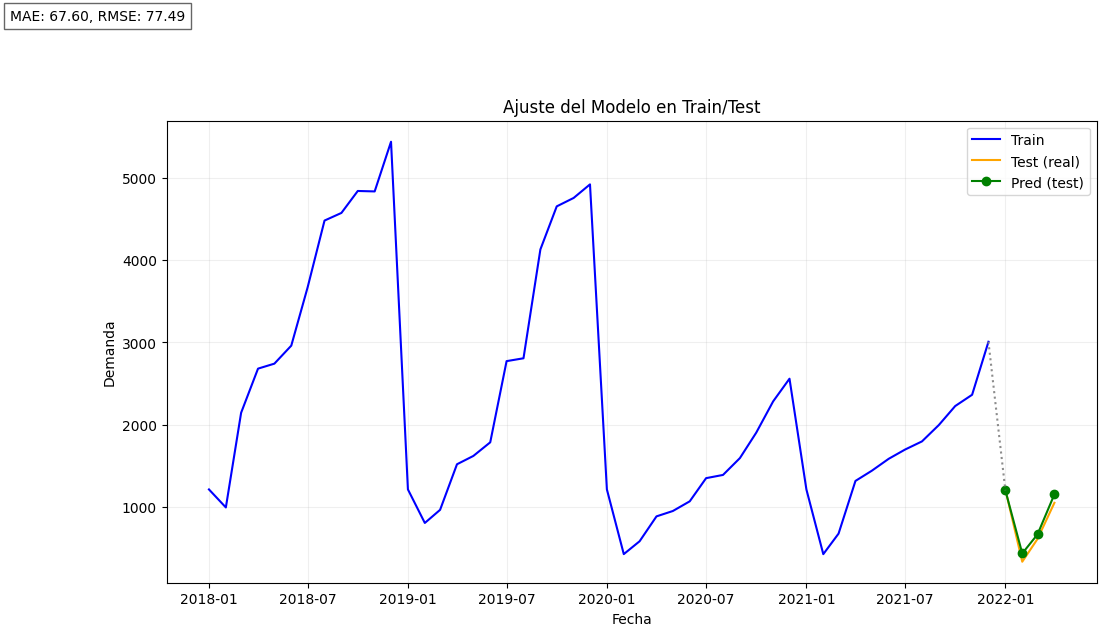

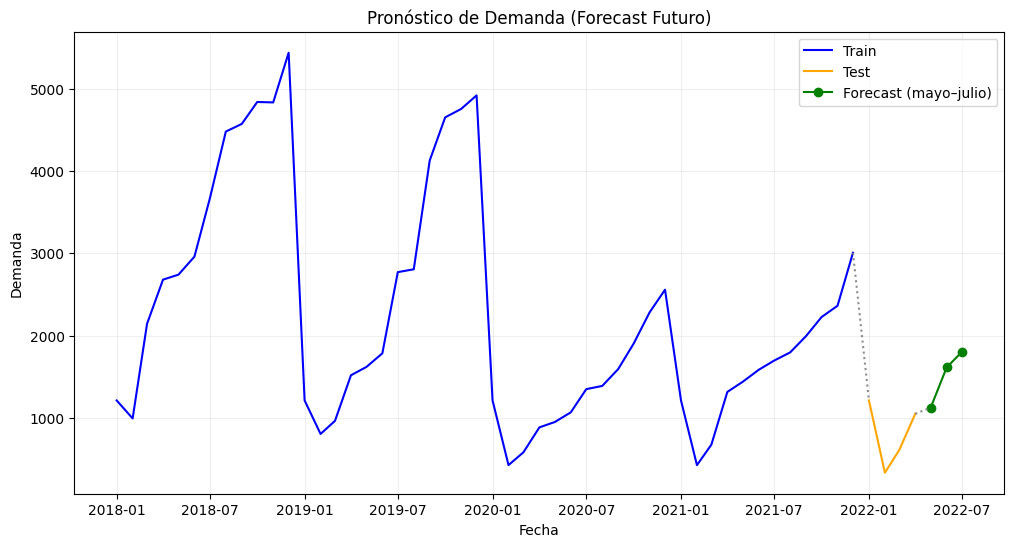

Archivo con resultados guardado en '../data/processed\full_forecast.xlsx'


In [7]:
# Ruta del modelo ya guardado ()
saved_model_path = "../models/forecast/best_xgb_model.pkl"

# ---------------- CARGAR el modelo guardado para predecir test ----------------
if not os.path.exists(saved_model_path):
    raise FileNotFoundError(f"No se encontró el archivo del modelo en: {saved_model_path}. "
                            "Guarda el modelo en esa ruta antes de ejecutar este script.")

try:
    model_test = joblib.load(saved_model_path)
    print(f"Modelo cargado correctamente desde: {saved_model_path}")
except Exception as e:
    raise RuntimeError(f"Error al cargar el modelo desde {saved_model_path}: {e}")

# Selección de train-sub y test como en tu script (solo para obtener índices/valores a plotear)
X_train_sub = X_all.loc[:train_end]
y_train_sub = y_all.loc[X_train_sub.index]

# Predicciones en el rango de test (ene-abr 2022) usando el modelo cargado
X_test_slice = X_all.loc[test_start:test_end]
y_test_pred_log = model_test.predict(X_test_slice)
y_test_pred = np.expm1(y_test_pred_log)   # volver a escala original

# Definir series de train y test (en log) para trazarlas en escala original
y_train = y_all.loc[:train_end]
y_test  = y_all.loc[test_start:test_end]

# ---------------- Reentrenar mejor modelo con todo hasta abr-2022 (para forecast futuro) ----------------
X_train_full = X_all.loc[:test_end]
y_train_full = y_all.loc[X_train_full.index]

model_forecast = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.05, verbosity=0)
model_forecast.fit(X_train_full, y_train_full)

# Generar features futuros (mayo–julio 2022)
future_dates = pd.date_range(start="2022-05-01", end="2022-07-01", freq="MS")
df_future = pd.DataFrame(index=future_dates)
df_future["y"] = np.nan

# Construir df_full concatenando historial (df_feat["y"]) con periodo futuro
df_full = pd.concat([df_feat[["y"]], df_future])  # df_feat debe contener la serie histórica "y"

# Lags y medias móviles
for lag in [1, 2, 3, 6, 12]:
    df_full[f"lag_{lag}"] = df_full["y"].shift(lag)
df_full["rmean_3"] = df_full["y"].shift(1).rolling(3, min_periods=1).mean()
df_full["rmean_12"] = df_full["y"].shift(1).rolling(12, min_periods=1).mean()
df_full["month"] = df_full.index.month
df_full = pd.get_dummies(df_full, columns=["month"], prefix="m", drop_first=True)

# Asegúrate de que las columnas de X_future coincidan con X_all (rellena con 0 si hace falta)
X_future = df_full.loc[future_dates].drop(columns=["y"])
X_future = X_future.reindex(columns=X_all.columns, fill_value=0)

forecast_log = model_forecast.predict(X_future)
forecast = np.expm1(forecast_log)

# ---------------- Gráfico 1: Train + Test (reales) + Predicciones en test ----------------
plt.figure(figsize=(12,6))

# series en escala original
y_train_orig = np.expm1(y_train)
y_test_orig  = np.expm1(y_test)

plt.plot(y_train_orig.index, y_train_orig, label="Train", color="blue")
plt.plot(y_test_orig.index, y_test_orig, label="Test (real)", color="orange")
plt.plot(y_test_orig.index, y_test_pred, label="Pred (test)", color="green", marker="o")

# Línea punteada que conecta el final de la train con el inicio de la pred (gráfico 1)
last_train_date = y_train.index[-1]
last_train_val  = np.expm1(y_train.iloc[-1])
first_pred_date = y_test.index[0]
first_pred_val  = y_test_pred[0]

plt.plot([last_train_date, first_pred_date],
         [last_train_val, first_pred_val],
         linestyle=':', linewidth=1.5, alpha=0.9, color='gray', label='_nolegend_')

plt.title("Ajuste del Modelo en Train/Test")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.legend()

# Mostrar métricas (si df_summary está disponible)
try:
    mae_final = df_summary.loc["XGBoost","MAE"]
    rmse_final = df_summary.loc["XGBoost","RMSE"]
    plt.text(df_ts.index.min(), max(y_orig)*0.9,
             f"MAE: {mae_final:.2f}, RMSE: {rmse_final:.2f}",
             fontsize=10, bbox=dict(facecolor="white", alpha=0.6))
except Exception:
    pass

plt.grid(alpha=0.2)
plt.show()

# ---------------- Gráfico 2: Train + Test (reales) + Forecast futuro ----------------
plt.figure(figsize=(12,6))
plt.plot(y_train_orig.index, y_train_orig, label="Train", color="blue")
plt.plot(y_test_orig.index, y_test_orig, label="Test", color="orange")
plt.plot(future_dates, forecast, label="Forecast (mayo–julio)", color="green", marker="o")

# Línea punteada 1: conecta el final de la train con el inicio de la test
first_test_date = y_test.index[0]
first_test_val  = np.expm1(y_test.iloc[0])
plt.plot([last_train_date, first_test_date],
         [last_train_val, first_test_val],
         linestyle=':', linewidth=1.5, alpha=0.9, color='gray', label='_nolegend_')

# Línea punteada 2: conecta el final de la test con el inicio del forecast
last_test_date = y_test.index[-1]
last_test_val  = np.expm1(y_test.iloc[-1])
first_forecast_date = future_dates[0]
first_forecast_val  = forecast[0]

plt.plot([last_test_date, first_forecast_date],
         [last_test_val, first_forecast_val],
         linestyle=':', linewidth=1.5, alpha=0.9, color='gray', label='_nolegend_')

plt.title("Pronóstico de Demanda (Forecast Futuro)")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# ---------------- Guardar resultados ----------------
df_results = pd.DataFrame({
    "y_train": y_train_orig,
})
df_results = df_results.join(pd.Series(y_test_orig, name="y_test"), how="outer")
df_results = df_results.join(pd.Series(y_test_pred, index=y_test.index, name="y_test_pred"), how="outer")
df_results = df_results.join(pd.Series(forecast, index=future_dates, name="forecast"), how="outer")

out_path = "../data/processed"
os.makedirs(out_path, exist_ok=True)
out_file = os.path.join(out_path, "full_forecast.xlsx")
df_results.to_excel(out_file)

print(f"Archivo con resultados guardado en '{out_file}'")

## Nota:

Si bien el gráfico de muestra, enviado en las indicaciones de la prueba, ubicaba la parte de test y predict en el mismo rango de tiempo, los separo tras la necesidad de simular un escenario real de incertibumbre (en el cúal no podríamos hacer test en ese mismo rango, dado que no se tienen esos datos).

La elección del modelo de serie de tiempo se escogió por: ser mejor en términos relativos a los que se evluaron con él; y, adecuarse mejor al fenómeno univariado (no tenemos features exógenas que expliquen la demanda, solo la demanda misma), si tuvieramas más características valdría la pena explorar ML no paramétrico, pues con solo una variable el r2 tiene valores buenos (no excelentes). En todo caso, es interesante notar que un 20% de la varianza, aprox., no la explica la demanda misma 
